In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import positioner as ps
import IPython 
import numpy as np
from matplotlib import pyplot
from astropy.io import fits

In [6]:
hdulist = fits.open("Targets_Tile_000341.fits")

In [7]:
target_ra = hdulist[1].data['RA']
target_dec = hdulist[1].data['DEC']

In [8]:
tile_id = hdulist[2].data['TILE_ID']
tile_ra = hdulist[2].data['TILE_RA']
tile_dec = hdulist[2].data['TILE_DEC']

29390


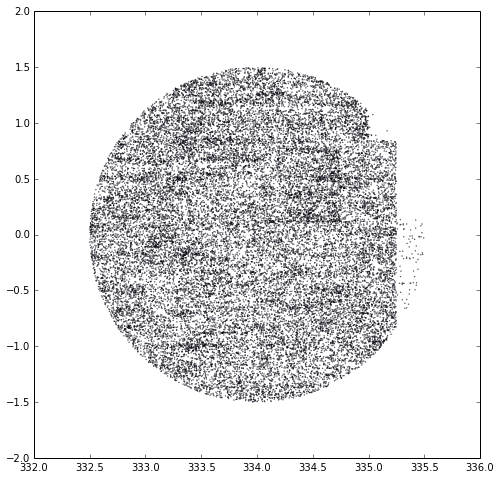

In [9]:
fig, ax = pyplot.subplots(figsize=(8, 8))
pyplot.scatter(target_ra, target_dec,s=0.1)
print np.size(target_dec)

In [10]:
def plate_dist(theta):
        """
        Returns the radial distance on the plate (mm) given the angle (radians).
        This is a fit to the provided data
        """
        p = np.array([8.297E5,-1750.0,1.394E4,0.0])
        radius = 0.0
        for i in range(4):
            radius = theta*radius + p[i]
        return radius

In [11]:
def radec2xy(object_ra, object_dec, tile_ra, tile_dec):
    """
    Returns the x,y coordinats of an object on the plate.
    It takes as an input the ra,dec coordinates ob the object 
    and the ra,dec coordinates of the plate's center.
    """
    object_theta = (90.0 - object_dec)*np.pi/180.0
    object_phi = object_ra*np.pi/180.0
    o_hat0 = np.sin(object_theta)*np.cos(object_phi)
    o_hat1 = np.sin(object_theta)*np.sin(object_phi)
    o_hat2 = np.cos(object_theta)
    
    tile_theta = (90.0 - tile_dec)*np.pi/180.0
    tile_phi = tile_ra*np.pi/180.0
    t_hat0 = np.sin(tile_theta)*np.cos(tile_phi)
    t_hat1 = np.sin(tile_theta)*np.sin(tile_phi)
    t_hat2 = np.cos(tile_theta)
    
    
    #we make a rotation on o_hat, so that t_hat ends up aligned with 
    #the unit vector along z. This is composed by a first rotation around z
    #of an angle pi/2 - phi and a second rotation around x by an angle theta, 
    #where theta and phi are the angles describin t_hat.
    
    costheta = t_hat2
    sintheta = np.sqrt(1.0-costheta*costheta) + 1E-10
    cosphi = t_hat0/sintheta
    sinphi = t_hat1/sintheta
    
    #First rotation, taking into account that cos(pi/2 -phi) = sin(phi) and sin(pi/2-phi)=cos(phi)
    n_hat0 = sinphi*o_hat0 - cosphi*o_hat1
    n_hat1 = cosphi*o_hat0 + sinphi*o_hat1
    n_hat2 = o_hat2
    
    #Second rotation
    nn_hat0 = n_hat0
    nn_hat1 = costheta*n_hat1 - sintheta*n_hat2
    nn_hat2 = sintheta*n_hat1 + costheta*n_hat2
    
    #Now find the radius on the plate
    theta = np.sqrt(nn_hat0*nn_hat0 + nn_hat1*nn_hat1)
    radius = plate_dist(theta)
    x = radius * nn_hat0/theta
    y = radius * nn_hat1/theta
    
    return x,y

In [12]:
x_target, y_target = radec2xy(target_ra, target_dec, tile_ra[0], tile_dec[0])

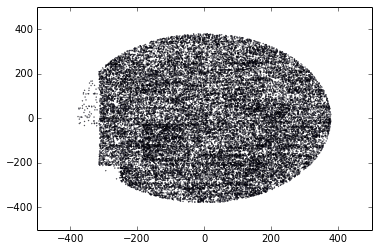

In [13]:
pyplot.scatter(x_target, y_target, s=0.1)

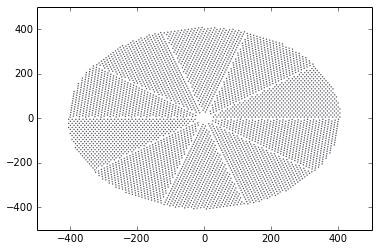

In [14]:
positioner_file = "../../surveyplan/data/pos_on_z1.txt"
positioner_data = np.loadtxt(positioner_file)
x_pos = positioner_data[:,1]
y_pos = positioner_data[:,2]
z_pos = positioner_data[:,3]
pyplot.scatter(x_pos, y_pos, s=0.1)
n_pos = np.size(x_pos)
R1 = 3.0
R2 = 3.0
patrol_radius = R1+R2

In [15]:
def assign_positioner(x_pos, y_pos, x_t, y_t):
    n_pos = np.size(x_pos)
    n_targets = np.size(x_t)
    x_on_t = np.zeros(n_pos)
    y_on_t = np.zeros(n_pos)
    target_available = np.zeros(n_targets)
    for i in range(n_pos):
        x_pos_i = x_pos[i]
        y_pos_i = y_pos[i]
    
        distance = np.sqrt((x_t-x_pos_i)**2 + (y_t - y_pos_i)**2)
        reachable = np.where((distance<patrol_radius)&(target_available==0))
        reachable = reachable[0]
        n_reachable = np.size(reachable)
        if (n_reachable):
            x_on_t[i] = x_target[reachable[0]]
            y_on_t[i] = y_target[reachable[0]]
            target_available[reachable[0]] = -1
        else:
            x_on_t[i] = x_pos_i
            y_on_t[i] = y_pos_i
    return x_on_t, y_on_t


In [16]:
def find_theta_phi(x_pos, y_pos, x_on_t, y_on_t):
    #amount on x and y that each fiber has to move to reach the target
    x_move = x_on_t - x_pos
    y_move = y_on_t - y_pos

    #the corresponding Theta and Phi for each positioner
    r = np.sqrt(x_move**2 + y_move**2) + 1E-12
    cos_alpha = (R2*R2 + R1*R1 - r*r)/(2.0*R2*R1)
    cos_beta = (R1*R1 + r*r - R2*R2)/(2.0*R1*r)
    cos_gamma = (r*r + R2*R2 - R1*R1)/(2.0*r*R2)
    cos_delta = x_move/r

    P = cos_alpha.copy()
    T = cos_alpha.copy()
    P[:] = np.inf
    T[:] = np.inf

    good = np.where(np.abs(cos_gamma)<=1.0)

    T[good] = 2.0*np.pi - np.arccos(cos_beta[good]) - np.arccos(cos_delta[good])
    P[good] = np.pi - np.arccos(cos_alpha[good])

    positive_y = np.where((y_move>=0.0) & (np.abs(cos_gamma)<=1.0))
    T[positive_y] = np.arccos(cos_delta[positive_y]) - np.arccos(cos_beta[positive_y])

    P[good] = np.rad2deg(P[good])
    T[good] = np.rad2deg(T[good])
    return T, P

In [17]:
x_on_target, y_on_target = assign_positioner(x_pos, y_pos, x_target, y_target)
T,P = find_theta_phi(x_pos, y_pos, x_on_target, y_on_target)

#generate the positioners on their final target positions
pos_list = []
for i in range(n_pos):
    pos_list.append(ps.positioner(offset_x=x_pos[i], offset_y=y_pos[i],Theta=T[i], Phi=P[i]))
    
#check for collisions, both type II and III
n_collision = 0
for i in range(n_pos):
    x_pos_i = x_pos[i]
    y_pos_i = y_pos[i]
    distance = np.sqrt((x_pos-x_pos_i)**2 + (y_pos - y_pos_i)**2)
    reachable = np.where(distance<patrol_radius*2.1)
    reachable = reachable[0]
    n_reachable = np.size(reachable)
    #we only check for collisions with neighboring positioners
    for j in reachable:
        if(i!=j):
            a, b = ps.find_collision_type(pos_list[i], pos_list[j])
            if(a|b):
                n_collision = n_collision + 1 

In [18]:
print("percentage of used fibers: %f\n"%(100.0*np.size(np.where(((x_on_target-x_pos)**2+(y_on_target-y_pos)**2)>0.0))/np.size(y_pos)))
print("collision percentage %f:"%(100.0*n_collision/np.size(np.where(np.fabs(x_on_target-x_pos)>0.0))))

percentage of used fibers: 85.019084

collision percentage 11.582492:
